# Logistic Regression (Binary)

**Short Theory Summary:**

A Logistic Regression predicts the probability of the target being a "0" or "1". Using the Logistic("Sigmoid") function it converts the linear inputs into the target range between 0 and 1 (exclusive). Using a threshold, all the probabilites are then converted to either 0 or 1.
The model is fitted using Maximum Likelihood Estimation. 

***

## Predicting Heart Disease with Logistic Regression:

* using a dataset from https://web.stanford.edu/~hastie/ElemStatLearn/datasets I will predict the probability of a patient having a heart disease from some health information from the patient.
* info on data: https://web.stanford.edu/~hastie/ElemStatLearn/datasets/SAheart.info.txt

Getting the data directly from website:

In [1]:
import pandas as pd
import numpy as np

heart = pd.read_csv("https://web.stanford.edu/~hastie/ElemStatLearn/datasets/SAheart.data", index_col = 0)
heart = heart.reset_index().drop(["row.names"], axis = "columns")
heart.head(2)

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1


**The columns:**

* sbp: systolic blood pressure
* tobacco		cumulative tobacco (kg)
* adiposity
* famhist: family history of heart disease (Present, Absent)
* obesity
* alcohol: current alcohol consumption
* age: age at onset
* **chd: target: coronary heart disease (1 = yes, 0 = no)**

Convert famhist to integer:

In [2]:
heart.loc[heart.famhist == "Absent", "famhist"] = "0"
heart.loc[heart.famhist == "Present", "famhist"] = "1"
heart[["famhist"]] = heart[["famhist"]].apply(pd.to_numeric)

In [3]:
features = heart.drop("chd", axis = "columns")
target = heart["chd"]
has_d = heart.loc[heart.chd == 1]
no_d = heart.loc[heart.chd == 0]

### Exploring The Data With Boxplots

Boxplots are a common tool to visualize features and mostly provide information about their distribution.
* Whiskers depict the range of values (usually defined as the lower quartile - 1,5 * IQR and upper quartile + 1,5 * IQR)
* Lower and upper quartiles are the edge of the box
* Line in the box is the median
* Outliers are single data points outside whiskers 

**Comparing Age for patients with and without heart disease:**

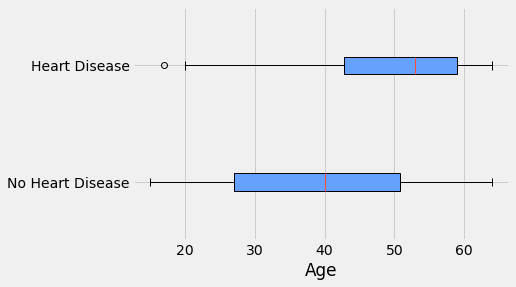

In [4]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
age_box = plt.boxplot([no_d["age"], has_d["age"]], labels = ["No Heart Disease", "Heart Disease"], vert = False,  patch_artist=True)
for patch in age_box["boxes"]: patch.set_facecolor("#66a1ff")
plt.xlabel("Age")
plt.show()

* Patients with a Heart Disease tend to be older but are still existant in every age group.

**Comparing Tobacco Consumption:**

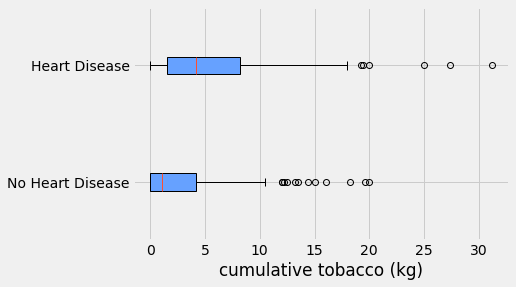

In [5]:
tob_box = plt.boxplot([no_d["tobacco"], has_d["tobacco"]], labels = ["No Heart Disease", "Heart Disease"], vert = False,  patch_artist=True)
for patch in tob_box["boxes"]: patch.set_facecolor("#66a1ff")
plt.xlabel("cumulative tobacco (kg)")
plt.show()

* Patients who had a Heart Disease also tend to have higher cumulative tobacco consumption despite many patients with tobacco consumption between 0 and 5 kg who didnt have a heart disease. Additionally, all patients with tobacco consmuption of more than 20kg ended up having a heart disease.

**Comparing Blood Pressure:**

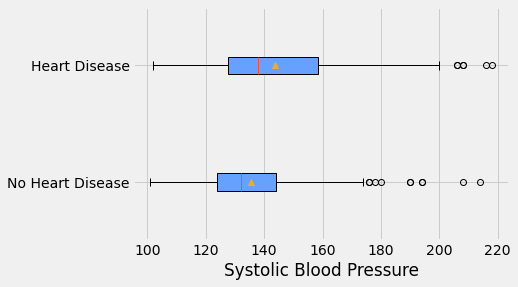

In [6]:
blo_box = plt.boxplot([no_d["sbp"], has_d["sbp"]], labels = ["No Heart Disease", "Heart Disease"], vert = False,  patch_artist=True, showmeans = True)
for patch in blo_box["boxes"]: patch.set_facecolor("#66a1ff")
plt.xlabel("Systolic Blood Pressure")
plt.show()

## Modelling a Logistic Regression:

**Train-Test-Splitting:**

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

**Instantiating Model:**

In [8]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(random_state = 42, max_iter = 200)
lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)
y_proba = pd.DataFrame(lg.predict_proba(X_test))[1]

Sklearn uses a default threshold of 0,5 to predict the final target value of either 0 or 1. 

**Evaluating Performance and comparing thresholds:**

Default threshold = 0.5:

*Accuracy: proportion of correctly identifed classes in prediction*

In [9]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.7634408602150538

*Area under the curve:*

In [10]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.7200897308075773

Comparing different thresholds:

In [11]:
def prob_to_class(x, thresh):
    if (x > thresh):
        return 1
    else:
        return 0

In [12]:
thresholds = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7]

print("Threshold\tAccuracy\tAUC-Score")
for t in thresholds:
    y_pred2 = y_proba.apply(prob_to_class, args=(t,))
    print(str(t) + "\t" + str(accuracy_score(y_test, y_pred2))  + "\t" + str(roc_auc_score(y_test, y_pred2)))
    

Threshold	Accuracy	AUC-Score
0.3	0.6881720430107527	0.6981555333998006
0.35	0.6881720430107527	0.6856929212362911
0.4	0.7634408602150538	0.7387836490528416
0.45	0.7634408602150538	0.7325523429710867
0.5	0.7634408602150538	0.7200897308075773
0.55	0.7634408602150538	0.7013958125623131
0.6	0.7419354838709677	0.6657527417746759
0.7	0.7204301075268817	0.6176470588235294


After comparing different thresholds it still seems like the default threshold of 0.5 has the highest accuracy and area-under-the-curve.

*Confusion Matrix:*

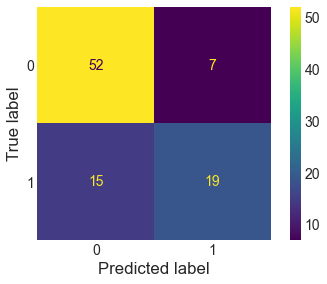

In [13]:
with plt.style.context("seaborn-dark"):
    from sklearn.metrics import plot_confusion_matrix
    plot_confusion_matrix(lg, X_test, y_test)
    plt.show()

* Sensivitiy (True Positive rate) measures the proportion of positives that are correctly identified; here: 19 / 34
* Specificity (True Negative rate) measures the proportion of negatives that are correctly identified; here: 51 / 59

In a machine learning context sensitivity is commonly referred to as **recall**.

In [14]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred)

0.5588235294117647

**precision** is the proportion of correctly identified positives of all positives(PPV)

In [15]:
from sklearn.metrics import precision_score
precision_score(y_test, y_pred)

0.7307692307692307

*The naive classification is proportion of all positives of all samples.*

Even though the sensitivity of 0.5588 is an improvement to the naive classification, it's still not a very good value especially considering that detecting possible heart disease is crucial.

It might be a good idea to look for lower thresholds in order to increase the sensitivity:

In [18]:
thresholds = [0.3, 0.35, 0.4, 0.45, 0.5, 0.6]

print("Threshold\tRecall")
for t in thresholds:
    y_pred2 = y_proba.apply(prob_to_class, args=(t,))
    print(str(t) + "\t" + str(recall_score(y_test, y_pred2)))

Threshold	Recall
0.3	0.7352941176470589
0.35	0.6764705882352942
0.4	0.6470588235294118
0.45	0.6176470588235294
0.5	0.5588235294117647
0.6	0.38235294117647056


* A threshold of 0.4 has an improved sensitivity of 0.647 as well as an accuracy of 0.763.

In [32]:
final_predictions = y_proba.apply(prob_to_class, args=(0.40,))
print("Threshold: \t0.40\n" + "Accuracy: \t" + str(accuracy_score(y_test, final_predictions)) + "\nSensitivity: \t" + str(recall_score(y_test, final_predictions)))

Threshold: 	0.40
Accuracy: 	0.7634408602150538
Sensitivity: 	0.6470588235294118
